In [2]:
!pip install qutip


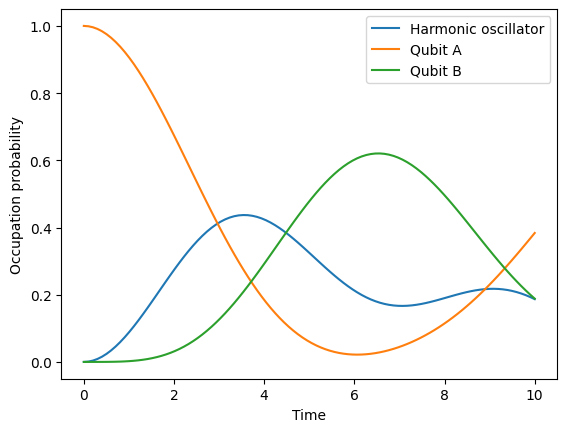

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define parameters
N = 5  # Number of Fock states for the harmonic oscillator
wc = 0.5 * 2 * np.pi  # Frequency of the harmonic oscillator
wa = 1.0 * 2 * np.pi  # Frequency of qubit A
wb = 1.1 * 2 * np.pi  # Frequency of qubit B
g = 0.05 * 2 * np.pi  # Coupling strength

# Define operators
a = tensor(destroy(N), qeye(2), qeye(2))
sm_a = tensor(qeye(N), destroy(2), qeye(2))
sm_b = tensor(qeye(N), qeye(2), destroy(2))

# Hamiltonian for the system
H0 = wc * a.dag() * a + 0.5 * wa * sm_a.dag() * sm_a + 0.5 * wb * sm_b.dag() * sm_b
H_int = g * (a * sm_a.dag() + a.dag() * sm_a) + g * (a * sm_b.dag() + a.dag() * sm_b)
H = H0 + H_int

# Collapse operators
c_ops = [np.sqrt(0.1) * a]

# Initial state: qubit A in the excited state, qubit B in the ground state, oscillator in the ground state
psi0 = tensor(basis(N,0), basis(2,1), basis(2,0))

# Time evolution
tlist = np.linspace(0, 10, 100)
result = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm_a.dag() * sm_a, sm_b.dag() * sm_b])

# Plot results
plt.plot(tlist, result.expect[0], label='Harmonic oscillator')
plt.plot(tlist, result.expect[1], label='Qubit A')
plt.plot(tlist, result.expect[2], label='Qubit B')
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.legend()
plt.show()


In [26]:
tlist.shape, reconstruction_error.shape, reconstructed_data.shape

((100,), (3,), (100, 3))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.0420 - val_loss: 0.9830
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 1.0264 - val_loss: 0.9839
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 1.0134 - val_loss: 0.9849
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 1.0025 - val_loss: 0.9859
Epoch 5/100
1/1 [==============================] - 0s 42ms/step - loss: 0.9949 - val_loss: 0.9871
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 0.9902 - val_loss: 0.9885
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.9896 - val_loss: 0.9899
Epoch 8/100
1/1 [==============================] - 0s 37ms/step - loss: 0.9893 - val_loss: 0.9913
Epoch 9/100
1/1 [==============================] - 0s 37ms/step - loss: 0.9877 - val_loss: 0.9927
Epoch 10/100
1/1 [==============================] - 0s 39ms/step - loss: 0.9854 - val_loss: 0.9941
Epoch 11/100
1/1 [===

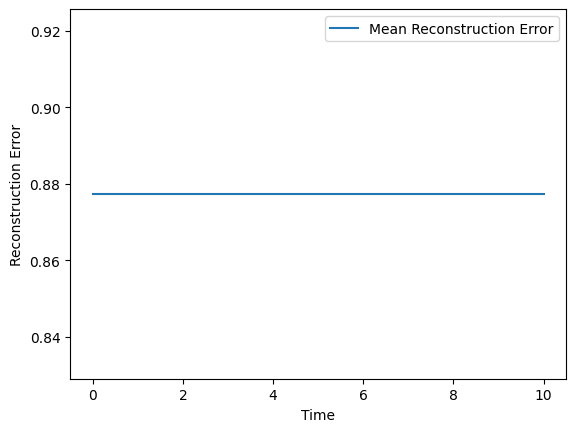

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense

# Time evolution simulation
tlist = np.linspace(0, 10, 100)
result = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm_a.dag() * sm_a, sm_b.dag() * sm_b])

# Extract the time evolution data
data = np.array([result.expect[0], result.expect[1], result.expect[2]])

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data.T).T

# Create training and test sets
X_train, X_test = train_test_split(data_standardized, test_size=0.2, random_state=42)

# Build an autoencoder model
input_dim = X_train.shape[1]
model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(input_dim, activation='tanh')
])

model.compile(optimizer='adam', loss='mse')

# Train the autoencoder on the normal behavior (training set)
model.fit(X_train, X_train, epochs=100, batch_size=16, shuffle=True, validation_data=(X_test, X_test))

# Reshape the input data for prediction
data_standardized_reshaped = data_standardized.T.reshape(-1, len(tlist))

# Reconstruct the data using the trained autoencoder
reconstructed_data_reshaped = model.predict(data_standardized_reshaped)

# Reshape the reconstructed data back to the original shape
reconstructed_data = reconstructed_data_reshaped.T

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(data_standardized.T - reconstructed_data), axis=0)
# Calculate the mean reconstruction error across all features
mean_reconstruction_error = np.mean(reconstruction_error)

# Plot the mean reconstruction error over time
plt.plot(tlist, np.full_like(tlist, mean_reconstruction_error), label='Mean Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


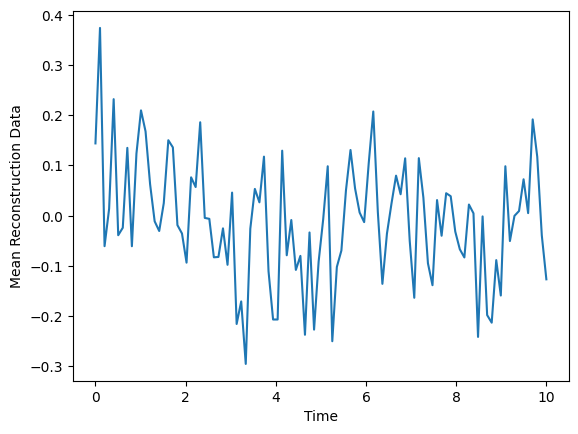

In [45]:
# Plot the mean reconstruction dara over time
plt.plot(tlist, reconstructed_data.mean(axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Reconstruction Data')
plt.show()


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense


# Time evolution simulation
tlist = np.linspace(0, 10, 100)
result = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm_a.dag() * sm_a, sm_b.dag() * sm_b])

# Extract the time evolution data
data = np.array([result.expect[0], result.expect[1], result.expect[2]])

# Feature Engineering
skewness = np.mean((data - np.mean(data, axis=1, keepdims=True))**3, axis=1)
kurtosis = np.mean((data - np.mean(data, axis=1, keepdims=True))**4, axis=1)



# Truncate or pad the autocorrelation array to match the size of the other feature arrays
max_size = max(skewness.size, kurtosis.size, fourier_transform.size)
autocorr_padded = np.pad(autocorr, ((0, 0), (0, max_size - autocorr.shape[1])))

# Resize Fourier transform array to match the size of other feature arrays
fourier_transform_resized = np.resize(fourier_transform, (3, max_size))

# Stack all features together
features = np.vstack((skewness, kurtosis, autocorr_padded, fourier_transform_resized))

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features.T).T

# Create training and test sets
X_train, X_test = train_test_split(features_standardized, test_size=0.2, random_state=42)

# Build an autoencoder model
model = Sequential([
    Input(shape=(features_standardized.shape[1],)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(features_standardized.shape[1], activation='linear')
])

model.compile(optimizer='adam', loss='mse')

# Train the autoencoder
model.fit(X_train, X_train, epochs=100, batch_size=16, shuffle=True, validation_data=(X_test, X_test))

# Reconstruct the data using the trained autoencoder
reconstructed_data = model.predict(features_standardized)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(features_standardized - reconstructed_data), axis=1)

# Plot the reconstruction error for each observable
plt.plot(tlist, reconstruction_error[:3], label='Higher-Order Moments')
plt.plot(tlist, reconstruction_error[3:6], label='Autocorrelation')
plt.plot(tlist, reconstruction_error[6:9], label='Fourier Transform')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 2 has size 300

In [51]:

skewness.shape, kurtosis.shape , autocorr_padded.shape , fourier_transform_resized.shape

((3,), (3,), (3, 300), (3, 300))